In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import random
import pickle5 as pickle

import matplotlib.pyplot as plt
%matplotlib inline

from helpers import *
from skimage.morphology import skeletonize, thin
from scipy import ndimage

In [2]:
# load data
with open('../data/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
print(f'Raw data shape: {raw_data.shape}')

# remove test set
data = raw_data[raw_data.dataset != 'test'].reset_index(drop=True)
print(f'Train/dev data shape: {data.shape}')
#data.head()

Raw data shape: (172950, 11)
Train/dev data shape: (147007, 11)


In [3]:
# calculate density of dies in wafer map
# as represented by nonzero elements
def wafer_density(row, col, x, y):
    nonzeros = np.count_nonzero(row[col])
    pixels = row[x] * row[y]
    return nonzeros/pixels

data['density'] = data.apply (lambda row: wafer_density(row, 'waferMap', 'x_', 'y_'), axis=1)

# create a dictionary of the max density for each lot
# assume that this represents the full uncorrupted wafer map
lot_density = data.groupby('lotName').density.max().to_dict()

# what percentage of density is missing, if any?
def missing_density(row, lot, density, dictionary):
    missing_pct = (dictionary[row[lot]] - row[density]) / dictionary[row[lot]]
    return missing_pct

data['missing_density'] = data.apply (lambda row: missing_density(row, 'lotName', 'density', lot_density), axis=1)

In [4]:
# resize images to 60x60
data['waferMap60'] = data.waferMap.apply(lambda x: sk_resize(x/2, [60, 60], preserve_range=True, anti_aliasing=True))

In [50]:
# add binarized map column
def binarize(x):
    im_bool = x >= 0.6
    im_bin = im_bool * 1
    return im_bin
    
data['binaryMap'] = data.waferMap60.apply(lambda x: binarize(x))

In [51]:
data.failureType.unique()

array(['none', 'Loc', 'Edge-Loc', 'Center', 'Scratch', 'Near-full',
       'Random', 'Edge-Ring', 'Donut'], dtype=object)

In [52]:
fig_size = [8,8]
cmap = 'inferno'

In [53]:
# picked out "good" and "bad" examples of each failure type
good = [81093, 23883, 146546, 21963, 21504, 81735, 14937, 8777, 17502]
bad = [84792, 19099, 71986, 23280, 123406, 98254, 98185, 17960, 105729]

good_df = data.loc[good]
bad_df = data.loc[bad]

#### Exploring Morphological Thinning

##### Good Examples

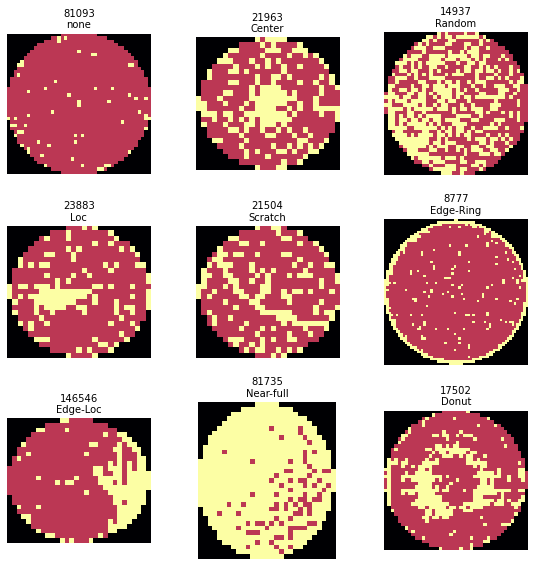

In [119]:
# original data
plot_list(good_df, good, fig_size=fig_size, col='waferMap', cmap=cmap)

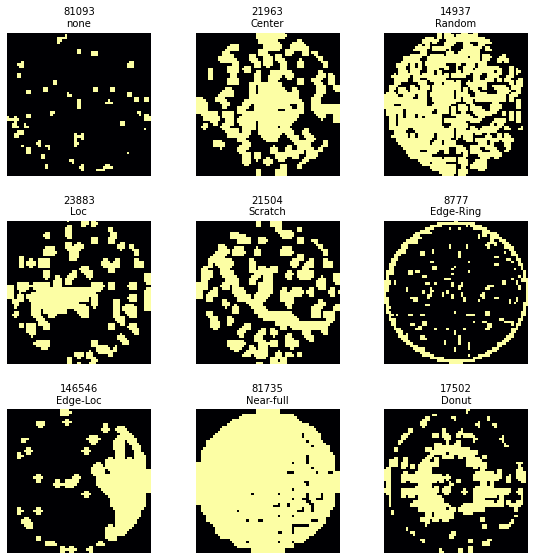

In [55]:
# binarized data
plot_list(good_df, good, fig_size=fig_size, col='binaryMap', cmap=cmap)

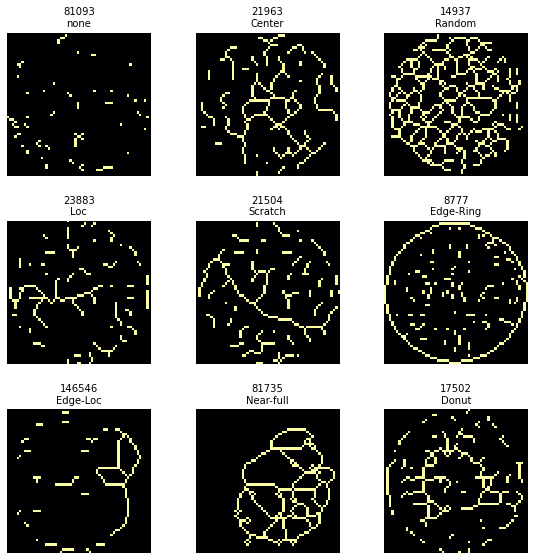

In [56]:
# apply thinning
good_df['thinMap'] = good_df.binaryMap.apply(lambda x: thin(x))
plot_list(good_df, good, fig_size=fig_size, col='thinMap', cmap=cmap)

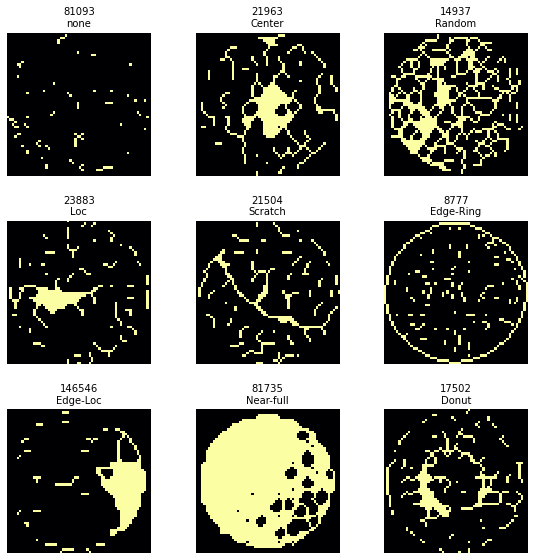

In [116]:
# apply partial thinning
good_df['pthinMap'] = good_df.binaryMap.apply(lambda x: thin(x, 2))
plot_list(good_df, good, fig_size=fig_size, col='pthinMap', cmap=cmap)

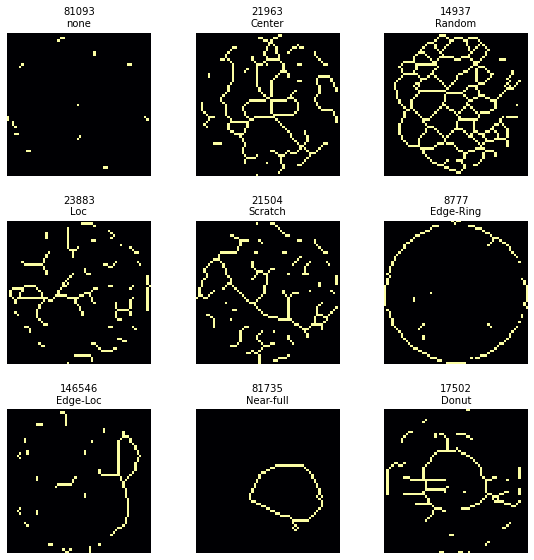

In [58]:
# apply median filter before thinning
good_df['fthinMap'] = good_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x,3)))
plot_list(good_df, good, fig_size=fig_size, col='fthinMap', cmap=cmap)

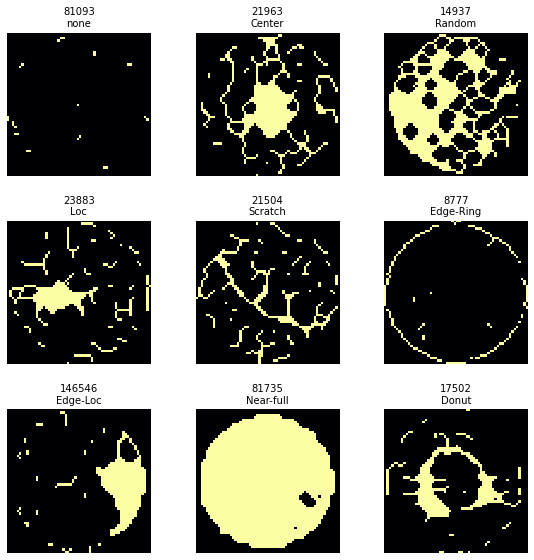

In [115]:
# apply median filter before thinning
good_df['fpthinMap'] = good_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x,3), 2))
plot_list(good_df, good, fig_size=fig_size, col='fpthinMap', cmap=cmap)

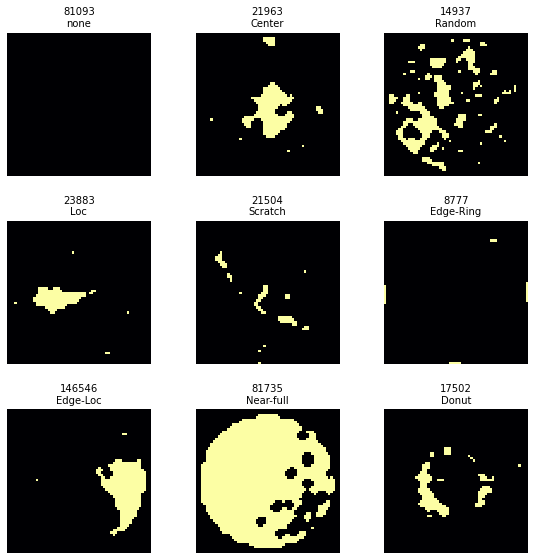

In [114]:
# apply median filter after thinning
good_df['fpthinMap'] = good_df.binaryMap.apply(lambda x: ndimage.median_filter(thin(x, 2), 3))
plot_list(good_df, good, fig_size=fig_size, col='fpthinMap', cmap=cmap)

##### Bad Examples

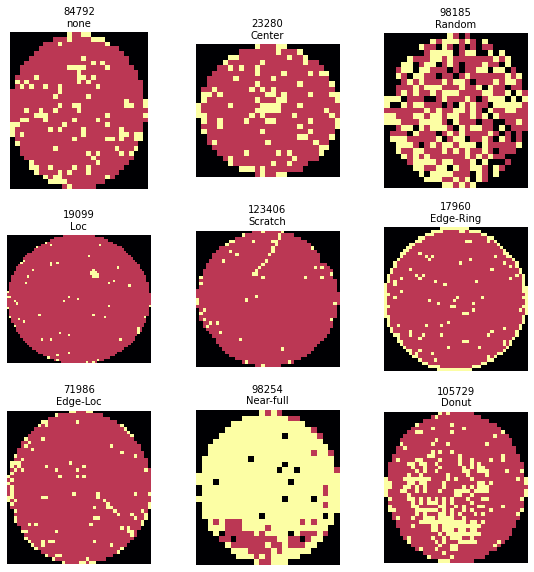

In [60]:
# original data
plot_list(bad_df, bad, fig_size=fig_size, col='waferMap', cmap=cmap)

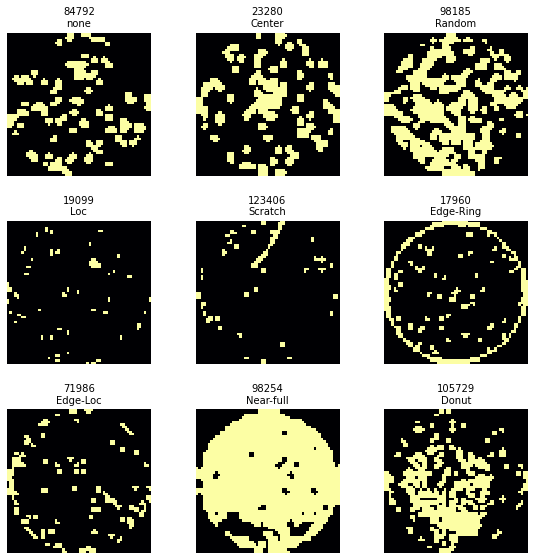

In [61]:
# binarized data
plot_list(bad_df, bad, fig_size=fig_size, col='binaryMap', cmap=cmap)

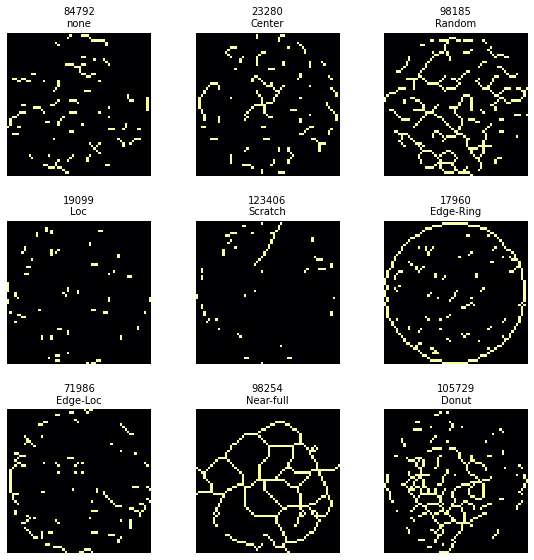

In [63]:
# apply thinning
bad_df['thinMap'] = bad_df.binaryMap.apply(lambda x: thin(x))
plot_list(bad_df, bad, fig_size=fig_size, col='thinMap', cmap=cmap)

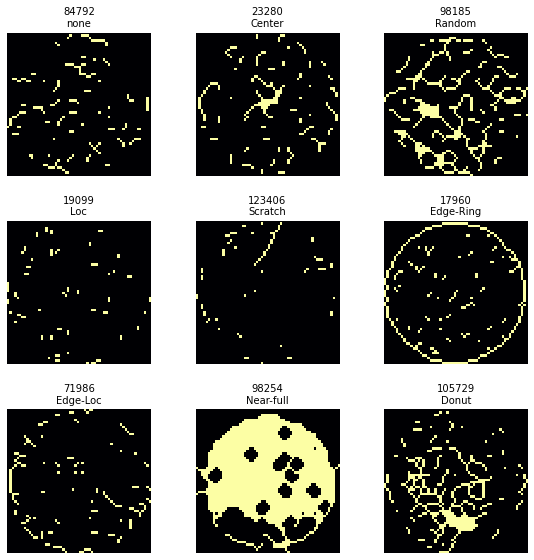

In [112]:
# apply thinning
bad_df['pthinMap'] = bad_df.binaryMap.apply(lambda x: thin(x, 2))
plot_list(bad_df, bad, fig_size=fig_size, col='pthinMap', cmap=cmap)

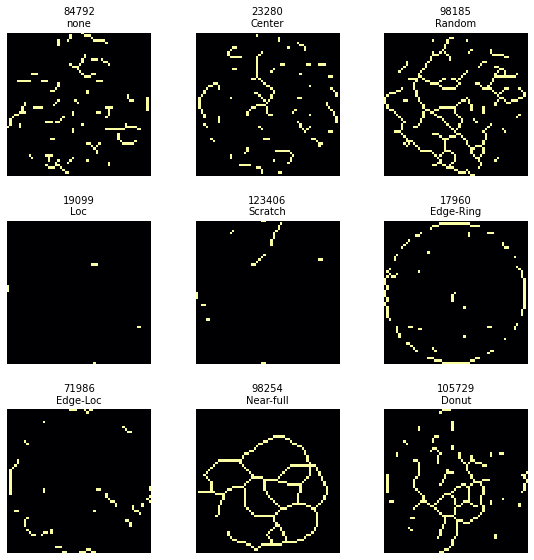

In [65]:
# apply median filter before thinning
bad_df['fthinMap'] = bad_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x,3)))
plot_list(bad_df, bad, fig_size=fig_size, col='fthinMap', cmap=cmap)

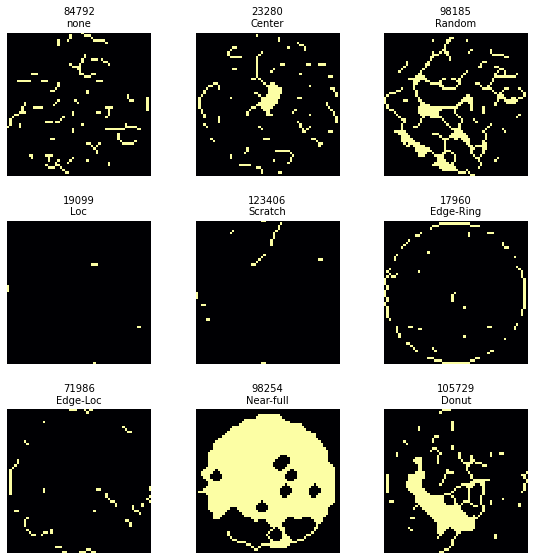

In [102]:
# apply median filter before thinning
bad_df['fpthinMap'] = bad_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x,3), 2))
plot_list(bad_df, bad, fig_size=fig_size, col='fpthinMap', cmap=cmap)

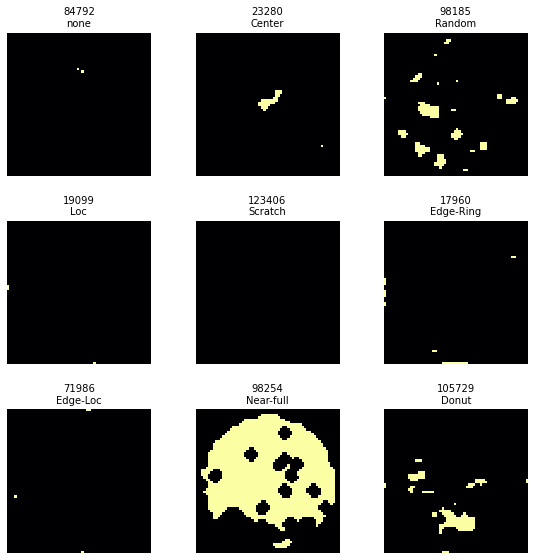

In [117]:
# apply median filter after thinning
bad_df['fpthinMap'] = bad_df.binaryMap.apply(lambda x: ndimage.median_filter(thin(x, 2), 3))
plot_list(bad_df, bad, fig_size=fig_size, col='fpthinMap', cmap=cmap)

#### Random Examples of Each Failure Type

In [67]:
number = 9

none count: 125316


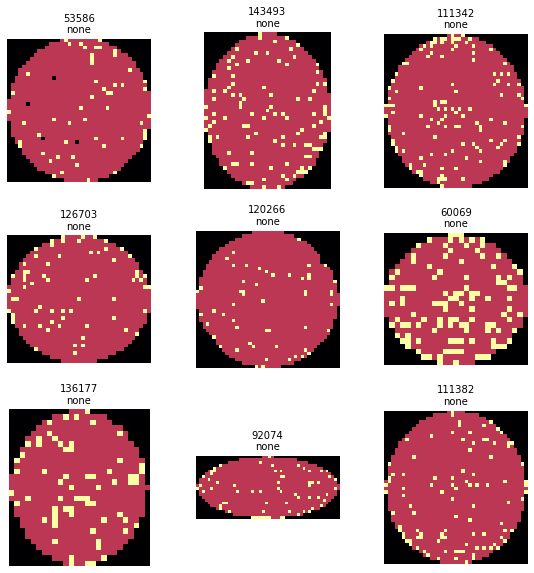

In [68]:
none = data.index[data['failureType'] == 'none'].tolist()
print(f'none count: {len(none)}')
random_none = random.sample(none, number)
none_df = data.loc[random_none]

plot_list(data, random_none, fig_size=fig_size, col='waferMap', cmap=cmap)

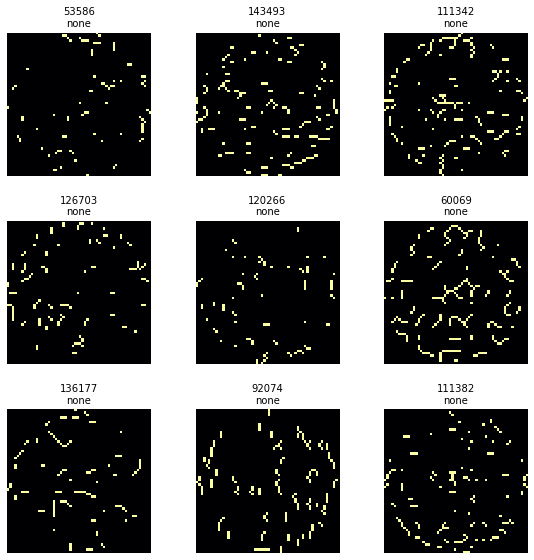

In [69]:
none_df['thinMap'] = none_df.binaryMap.apply(lambda x: thin(x))
plot_list(none_df, random_none, fig_size=fig_size, col='thinMap', cmap=cmap)

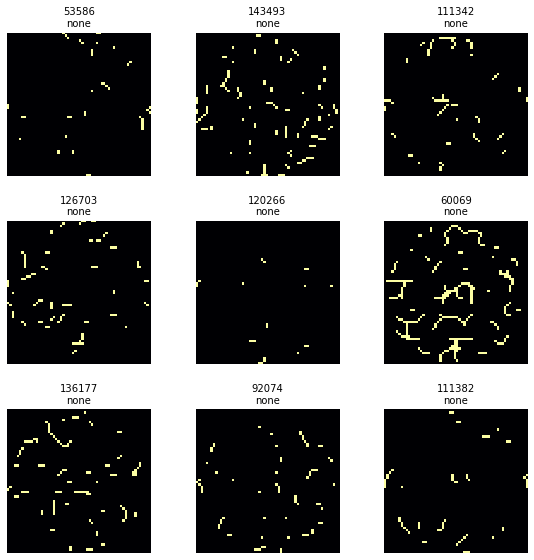

In [70]:
none_df['fpthinMap'] = none_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(none_df, random_none, fig_size=fig_size, col='fpthinMap', cmap=cmap)

Loc count: 3054


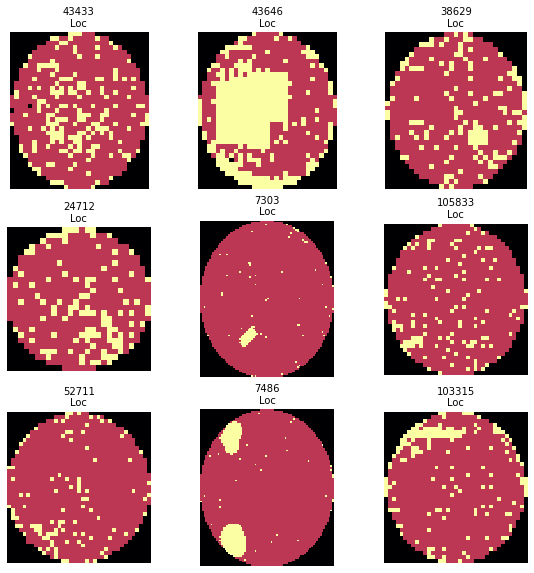

In [71]:
Loc = data.index[data['failureType'] == 'Loc'].tolist()
print(f'Loc count: {len(Loc)}')
random_Loc = random.sample(Loc, number)
Loc_df = data.loc[random_Loc]
 
plot_list(data, random_Loc, fig_size=fig_size, col='waferMap', cmap=cmap)

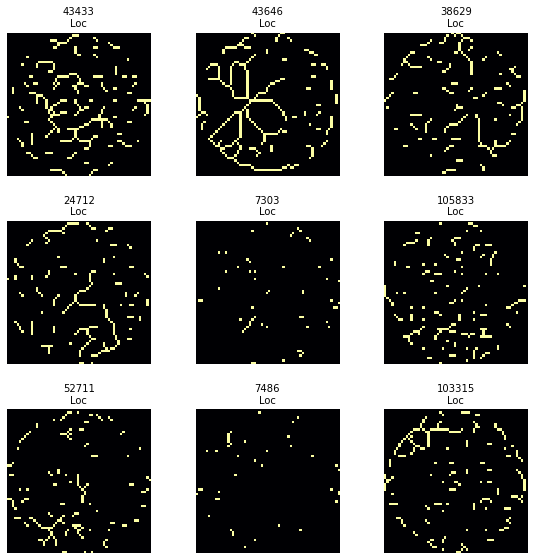

In [72]:
Loc_df['thinMap'] = Loc_df.binaryMap.apply(lambda x: thin(x))
plot_list(Loc_df, random_Loc, fig_size=fig_size, col='thinMap', cmap=cmap)

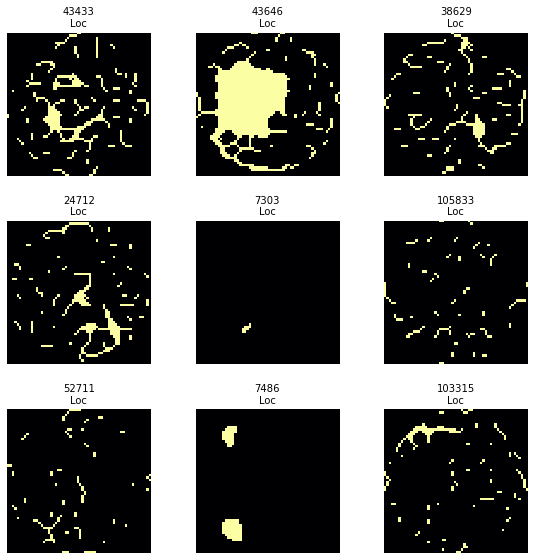

In [73]:
Loc_df['fpthinMap'] = Loc_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(Loc_df, random_Loc, fig_size=fig_size, col='fpthinMap', cmap=cmap)

EL count: 4410


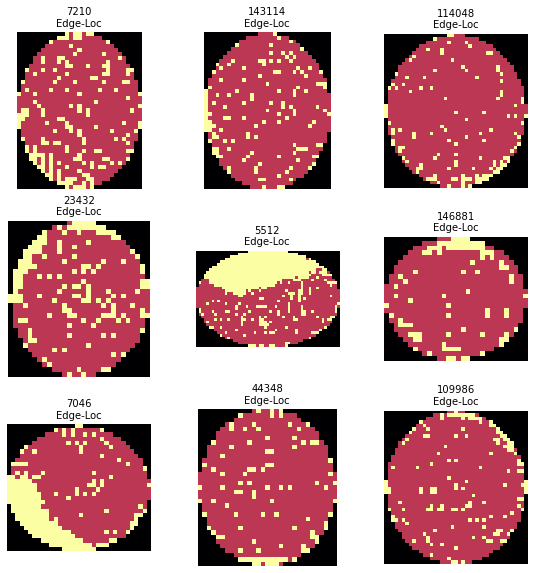

In [74]:
EL = data.index[data['failureType'] == 'Edge-Loc'].tolist()
print(f'EL count: {len(EL)}')
random_EL = random.sample(EL, number)
EL_df = data.loc[random_EL]
 
plot_list(data, random_EL, fig_size=fig_size, col='waferMap', cmap=cmap)

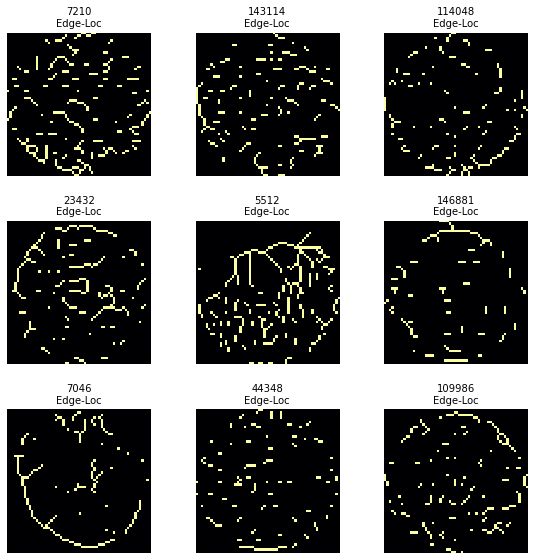

In [75]:
EL_df['thinMap'] = EL_df.binaryMap.apply(lambda x: thin(x))
plot_list(EL_df, random_EL, fig_size=fig_size, col='thinMap', cmap=cmap)

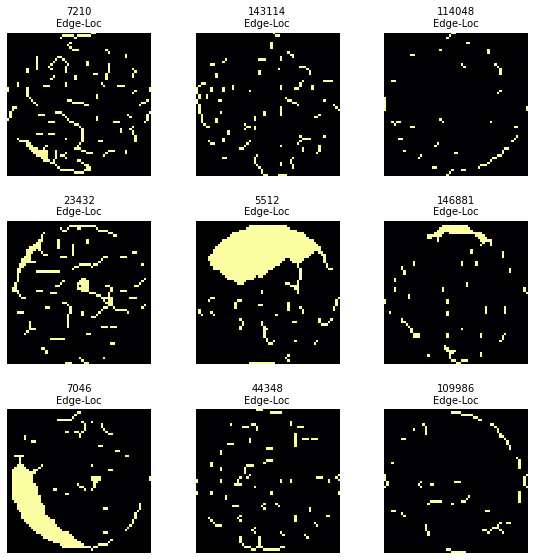

In [76]:
EL_df['fpthinMap'] = EL_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(EL_df, random_EL, fig_size=fig_size, col='fpthinMap', cmap=cmap)

CENTER count: 3650


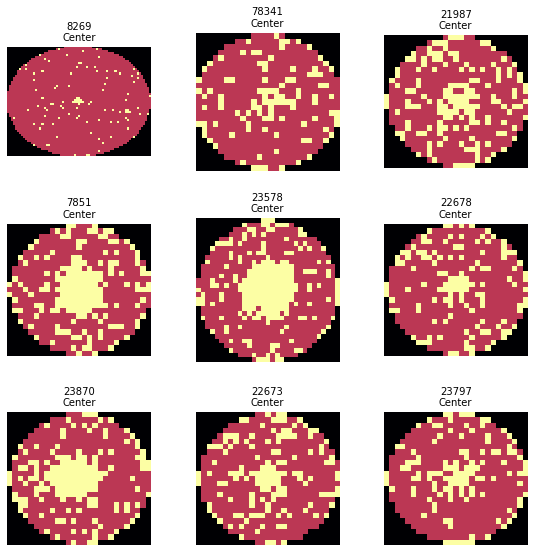

In [77]:
CENTER = data.index[data['failureType'] == 'Center'].tolist()
print(f'CENTER count: {len(CENTER)}')
random_CENTER = random.sample(CENTER, number)
CENTER_df = data.loc[random_CENTER]
 
plot_list(data, random_CENTER, fig_size=fig_size, col='waferMap', cmap=cmap)

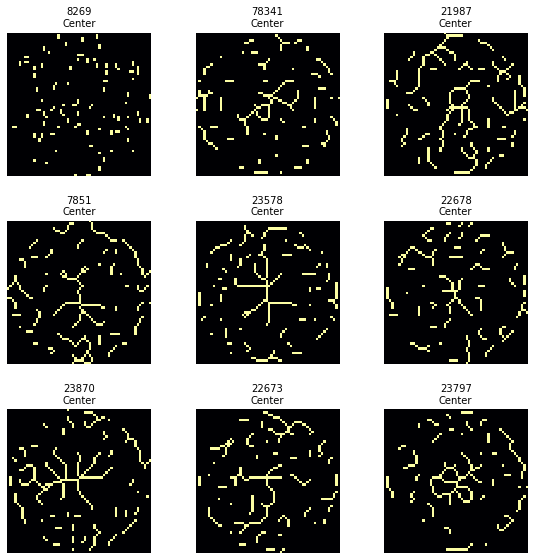

In [104]:
CENTER_df['thinMap'] = CENTER_df.binaryMap.apply(lambda x: thin(x))
plot_list(CENTER_df, random_CENTER, fig_size=fig_size, col='thinMap', cmap=cmap)

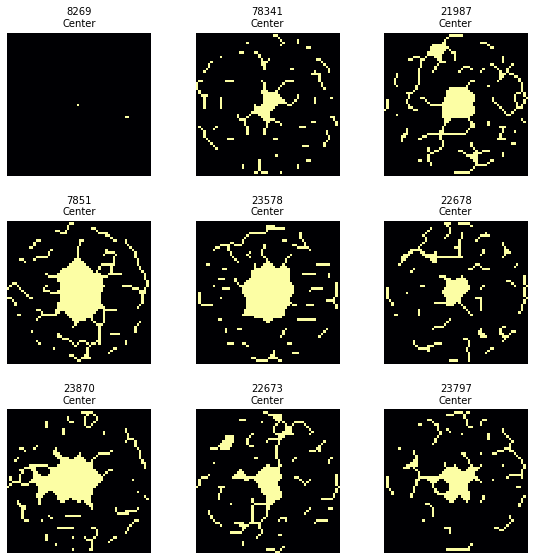

In [79]:
CENTER_df['fpthinMap'] = CENTER_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(CENTER_df, random_CENTER, fig_size=fig_size, col='fpthinMap', cmap=cmap)

ER count: 8228


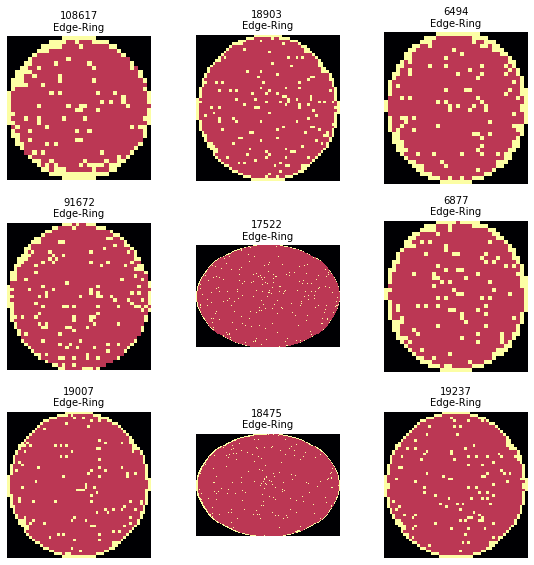

In [80]:
ER = data.index[data['failureType'] == 'Edge-Ring'].tolist()
print(f'ER count: {len(ER)}')
random_ER = random.sample(ER, number)
ER_df = data.loc[random_ER]
 
plot_list(data, random_ER, fig_size=fig_size, col='waferMap', cmap=cmap)

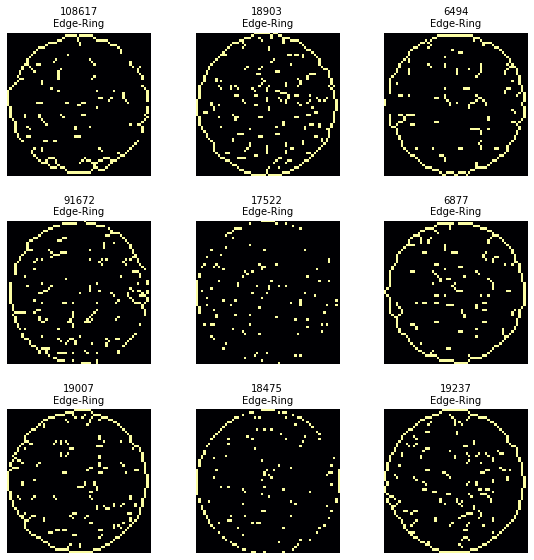

In [81]:
ER_df['thinMap'] = ER_df.binaryMap.apply(lambda x: thin(x))
plot_list(ER_df, random_ER, fig_size=fig_size, col='thinMap', cmap=cmap)

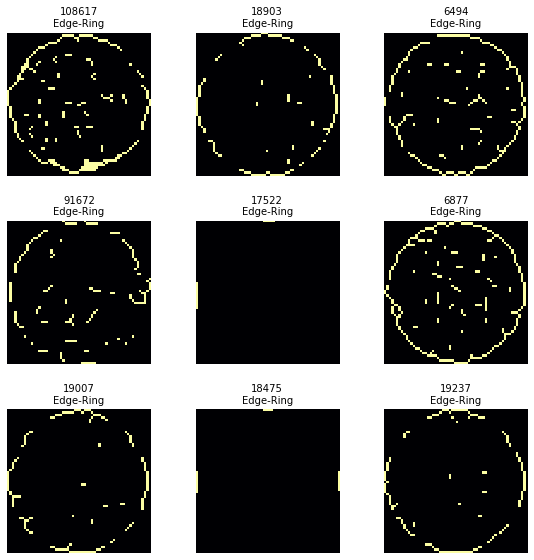

In [82]:
ER_df['fpthinMap'] = ER_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(ER_df, random_ER, fig_size=fig_size, col='fpthinMap', cmap=cmap)

SCRATCH count: 1014


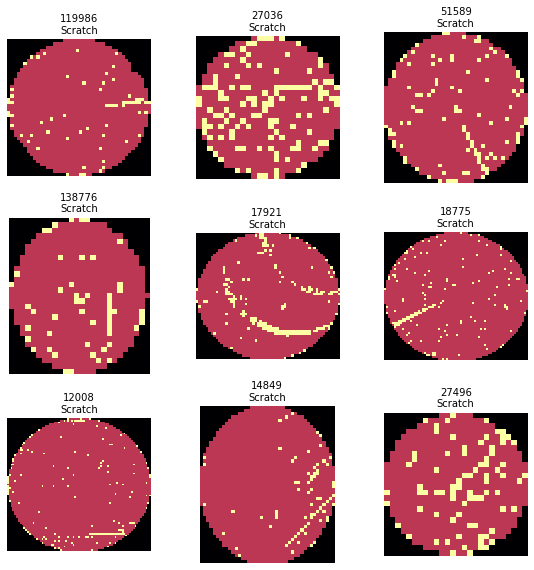

In [83]:
SCRATCH = data.index[data['failureType'] == 'Scratch'].tolist()
print(f'SCRATCH count: {len(SCRATCH)}')
random_SCRATCH = random.sample(SCRATCH, number)
SCRATCH_df = data.loc[random_SCRATCH]
 
plot_list(data, random_SCRATCH, fig_size=fig_size, col='waferMap', cmap=cmap)

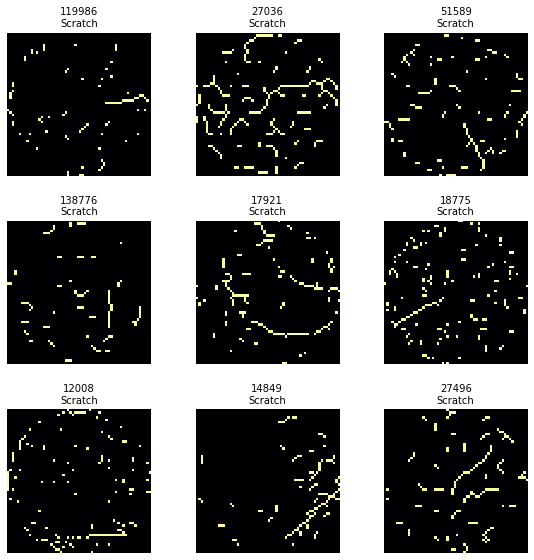

In [84]:
SCRATCH_df['thinMap'] = SCRATCH_df.binaryMap.apply(lambda x: thin(x))
plot_list(SCRATCH_df, random_SCRATCH, fig_size=fig_size, col='thinMap', cmap=cmap)

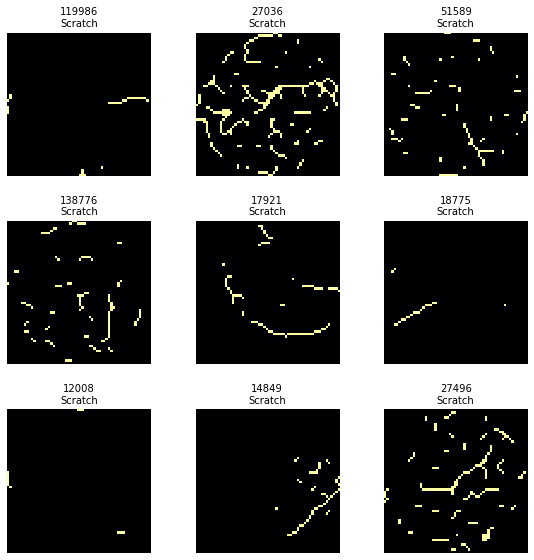

In [85]:
SCRATCH_df['fpthinMap'] = SCRATCH_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(SCRATCH_df, random_SCRATCH, fig_size=fig_size, col='fpthinMap', cmap=cmap)

rand count: 736


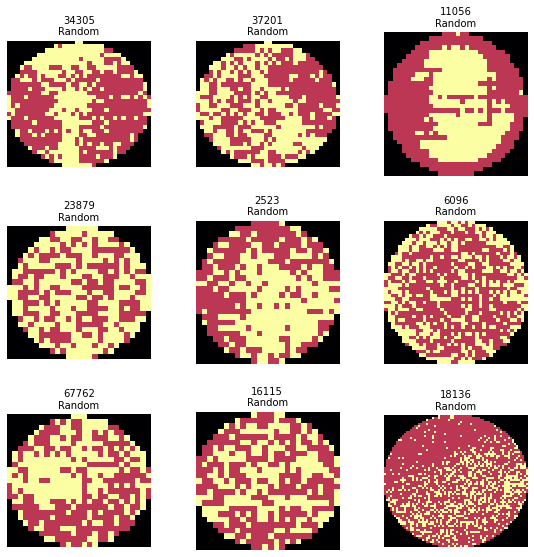

In [86]:
rand = data.index[data['failureType'] == 'Random'].tolist()
print(f'rand count: {len(rand)}')
random_rand = random.sample(rand, number)
rand_df = data.loc[random_rand]

plot_list(data, random_rand, fig_size=fig_size, col='waferMap', cmap=cmap)

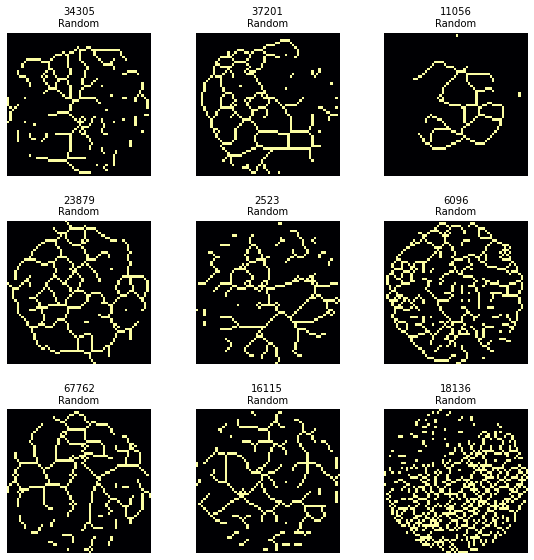

In [87]:
rand_df['thinMap'] = rand_df.binaryMap.apply(lambda x: thin(x))
plot_list(rand_df, random_rand, fig_size=fig_size, col='thinMap', cmap=cmap)

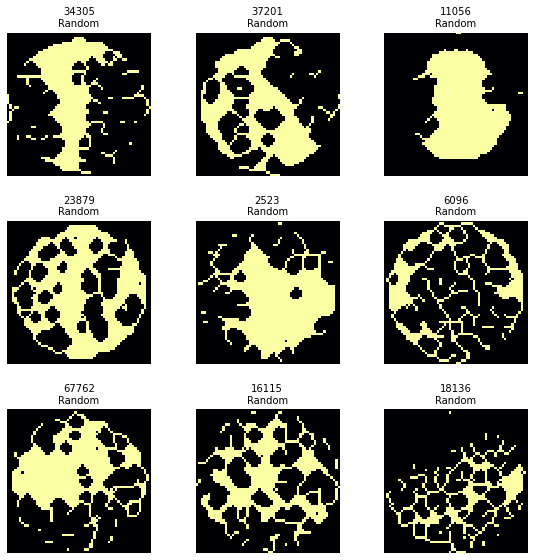

In [88]:
rand_df['fpthinMap'] = rand_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(rand_df, random_rand, fig_size=fig_size, col='fpthinMap', cmap=cmap)

NF count: 127


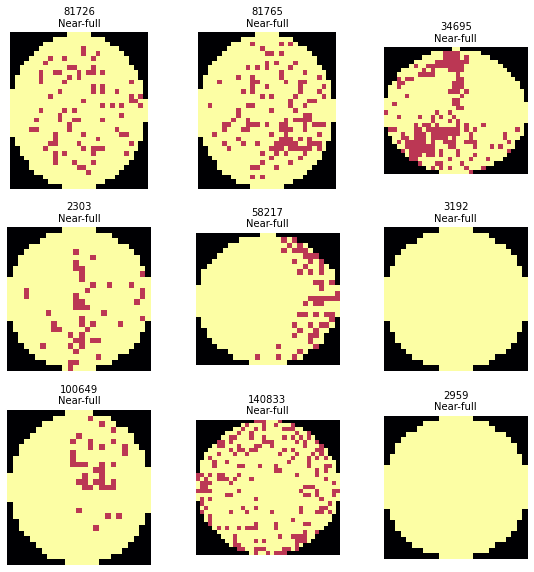

In [89]:
NF = data.index[data['failureType'] == 'Near-full'].tolist()
print(f'NF count: {len(NF)}')
random_NF = random.sample(NF, number)
NF_df = data.loc[random_NF]

plot_list(data, random_NF, fig_size=fig_size, col='waferMap', cmap=cmap)

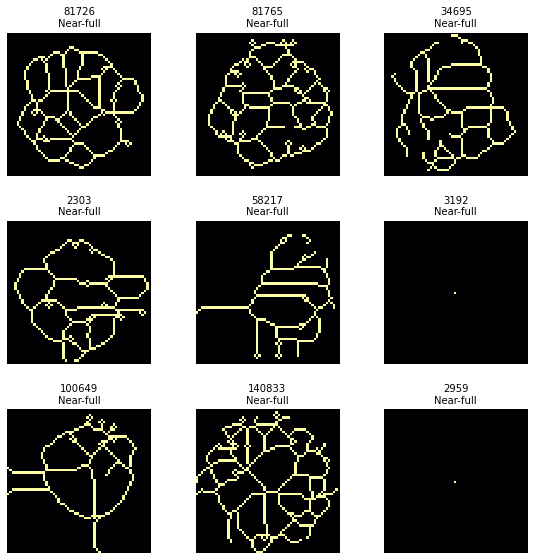

In [90]:
NF_df['thinMap'] = NF_df.binaryMap.apply(lambda x: thin(x))
plot_list(NF_df, random_NF, fig_size=fig_size, col='thinMap', cmap=cmap)

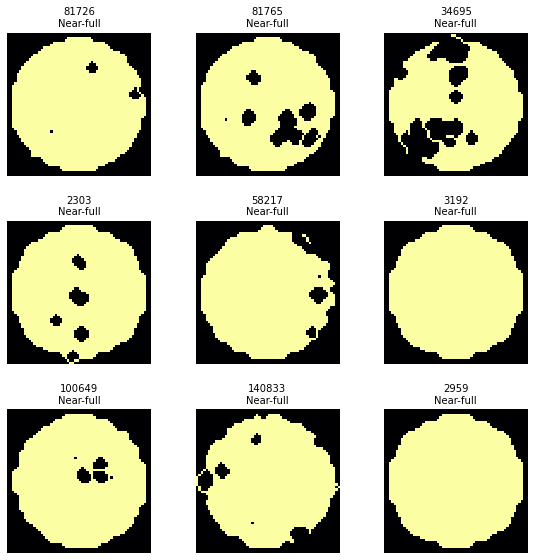

In [91]:
NF_df['fpthinMap'] = NF_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(NF_df, random_NF, fig_size=fig_size, col='fpthinMap', cmap=cmap)

donut count: 472


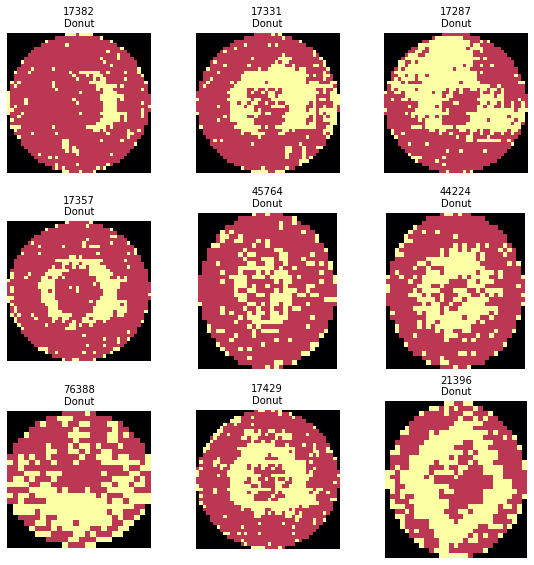

In [92]:
donut = data.index[data['failureType'] == 'Donut'].tolist()
print(f'donut count: {len(donut)}')
random_donut = random.sample(donut, number)
donut_df = data.loc[random_donut]

plot_list(data, random_donut, fig_size=fig_size, col='waferMap', cmap=cmap)

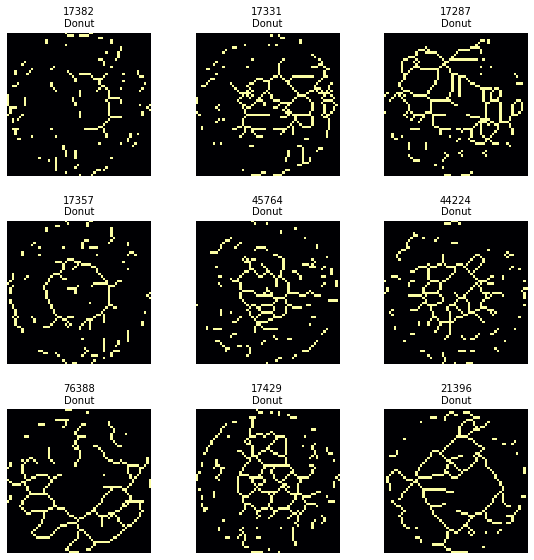

In [93]:
donut_df['thinMap'] = donut_df.binaryMap.apply(lambda x: thin(x))
plot_list(donut_df, random_donut, fig_size=fig_size, col='thinMap', cmap=cmap)

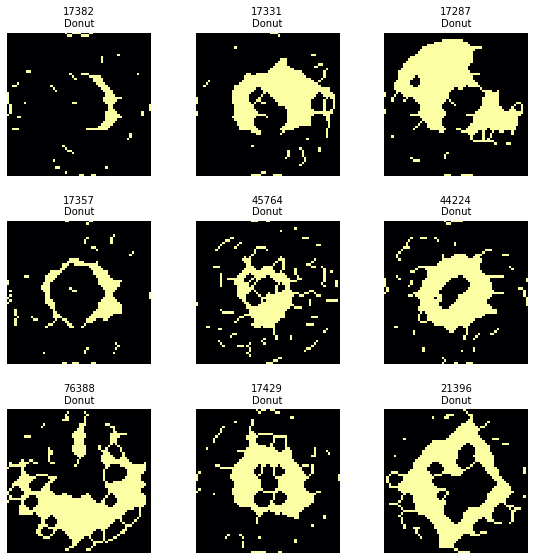

In [94]:
donut_df['fpthinMap'] = donut_df.binaryMap.apply(lambda x: thin(ndimage.median_filter(x, 3), 2))
plot_list(donut_df, random_donut, fig_size=fig_size, col='fpthinMap', cmap=cmap)